# 死亡・繁殖閾値 (DRT: death reproduction threshold) が変動するモデル

## 1. The model

In [1]:
using Dates
using Random: MersenneTwister
using StatsBase: mean, sample, Weights, countmap
using Graphs
using Parameters

using Plots: Plot, plot, plot!, histogram, heatmap, savefig, cgrad, closeall
using GraphPlot
using GraphRecipes
using Colors

using Test: @testset, @test

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [2]:
# color scheme
const DARK_BLUE = colorant"#2D579A"
const LIGHT_BLUE = colorant"#9BADCB"
const DARK_RED = colorant"#B32034"
const LIGHT_RED = colorant"#DBBEC1"
const GRAY = colorant"#E3E3E3"
const COLOR_GRAD = cgrad([DARK_RED, GRAY, DARK_BLUE], [0.0, 0.5, 1.0])

[DARK_RED, LIGHT_RED, GRAY, LIGHT_BLUE, DARK_BLUE] |> display
COLOR_GRAD |> display

In [3]:
@enum Strategy C D

@with_kw mutable struct Param
    N::Int = 1_000             # population (static)
    C_rate_init::Float64 = 0.5 # initial cooperator(C)'s freqtrialscy
    b::Float64 = 1.25          # benefit to defect
    c::Float64 = 0.25          # cost to cooperate
    n::Int = 10                # death and birth agent count
    m::Int = 2                 # added edge count
    θ::Float64 = 0.5           # DRT: death reproduction threshold
    ϵ::Float64 = 0.99          # selection pressure
    μ::Float64 = 0.01          # mutation rate
    generations::Int = 2_000   # time steps
    trials::Int = 25           # trial count
end

mutable struct Model
    p::Param
    payoff_table::Dict

    # agent's parameters
    strategy_vec::Vector{Strategy}     # agents' strategy
    payoff_vec::Vector{Float64}        # agents' payoff
    g::SimpleGraph
    rng::MersenneTwister

    function Model(p::Param)
        rng = MersenneTwister()

        payoff_table = Dict((C, C) => (1.0, 1.0), (C, D) => (-p.c, p.b), (D, C) => (p.b, -p.c), (D, D) => (0.0, 0.0))
        
        strategy_vec = [p.C_rate_init > rand(rng) ? C : D for _ in 1:p.N]

        payoff_vec = fill(0.0, p.N)

        g = erdos_renyi(p.N, p.N * p.m)
        
        return new(p, payoff_table, strategy_vec, payoff_vec, g, rng)
    end
end

@testset "Param & Model" begin
    m = Model(Param())
    @test m.p.N == nv(m.g) == length(m.strategy_vec) == length(m.payoff_vec) == 1_000
    @test m.payoff_table[(C, C)] == (1.0, 1.0)
    @test m.payoff_table[(C, D)] == (-0.25, 1.25)
    @test m.payoff_table[(D, C)] == (1.25, -0.25)
    @test m.payoff_table[(D, D)] == (0.0, 0.0)
    # @test m.strategy_vec == fill(D, m.p.N)
    @test m.payoff_vec == fill(0.0, m.p.N)
    @test mean(degree(m.g)) == 4
end;

Test Summary: | Pass  Total  Time
Param & Model |    7      7  0.3s


### 1.1. Interaction

In [4]:
function interaction!(m::Model)::Nothing
    m.payoff_vec .= 0.0

    for focal_id in 1:m.p.N, opponent_id in neighbors(m.g, focal_id)
        focal_id >= opponent_id && continue  # 同じ相手とは1度だけ対戦する

        (focal_strategy, opponent_strategy) = m.strategy_vec[[focal_id, opponent_id]]
        (focal_payoff, opponent_payoff) = m.payoff_table[(focal_strategy, opponent_strategy)]
        m.payoff_vec[focal_id] += focal_payoff
        m.payoff_vec[opponent_id] += opponent_payoff
    end
    
    return
end

@testset "interaction!" begin
    # pre-condiction
    m = Model(Param(N = 5))
    m.strategy_vec = [C, C, D, D, D]

    rem_edge!(m.g, 2, 3)
    for i in 1:4
        rem_edge!(m.g, i, 5)
    end
    @test degree(m.g) == [3, 2, 2, 3, 0]

    # execute
    interaction!(m)

    @test m.payoff_vec == [0.5, 0.75, 1.25, 2.5, 0.0]
end;

Test Summary: | Pass  Total  Time
interaction!  |    2      2  0.0s


### 1.2. Death and reproduction

In [5]:
function adjust_payoff!(m::Model)::Nothing
    # apply selection strength (ϵ)
    m.payoff_vec .= 1.0 .- m.p.ϵ .+ m.p.ϵ .* m.payoff_vec

    return
end

@testset "adjust_payoff!" begin
    @testset "ϵ = 1.0" begin
        m = Model(Param(N = 5, ϵ = 0.99))
        m.payoff_vec = [-0.2, -0.1, 0.0, 0.2, 0.4]

        # execute
        adjust_payoff!(m)

        @test m.payoff_vec ≈ [-0.188, -0.089, 0.01, 0.208, 0.406]
    end

    @testset "ϵ = 1.0" begin
        m = Model(Param(N = 5, ϵ = 1.0))
        m.payoff_vec = [-0.2, -0.1, 0.0, 1.2, 10.4]

        # execute
        adjust_payoff!(m)

        @test m.payoff_vec ≈ [-0.2, -0.1, 0.0, 1.2, 10.4]
    end

    @testset "ϵ = 0.1" begin
        m = Model(Param(N = 5, ϵ = 0.1))
        m.payoff_vec = [-0.2, -0.1, 0.0, 0.2, 0.4]

        # execute
        adjust_payoff!(m)

        @test m.payoff_vec ≈ [0.88, 0.89, 0.9, 0.92, 0.94]
    end

    @testset "max payoff is 0" begin
        m = Model(Param(N = 5, ϵ = 0.1))

        # execute
        adjust_payoff!(m)

        @test m.payoff_vec ≈ [0.9, 0.9, 0.9, 0.9, 0.9]
    end

    @testset "max payoff is 0" begin
        m = Model(Param(N = 5, ϵ = 0.99))

        # execute
        adjust_payoff!(m)

        @test m.payoff_vec ≈ [0.01, 0.01, 0.01, 0.01, 0.01]
    end
end;

Test Summary:  | Pass  Total  Time
adjust_payoff! |    5      5  0.1s


In [6]:
function death!(m::Model)::Vector{Int}
    death_id_vec = findall(<(m.p.θ), m.payoff_vec)
    diff_n = length(death_id_vec) - m.p.n

    if diff_n > 0
        # The number of deaths is too large, so narrow it down.
        death_id_vec = sample(m.rng, death_id_vec, m.p.n, replace = false)
    elseif diff_n < 0
        # The number of deaths is too small, so increase it.
        survived_id_vec = filter(∉(death_id_vec), 1:m.p.N)
        additional_death_id_vec = sample(m.rng, survived_id_vec, -diff_n, replace = false)
        append!(death_id_vec, additional_death_id_vec)
    end

    death_id_vec = sort(death_id_vec)

    deleteat!(m.payoff_vec, death_id_vec)
    deleteat!(m.strategy_vec, death_id_vec)
    rem_vertices!(m.g, death_id_vec, keep_order = true)

    return death_id_vec
end

function death_without_θ!(m::Model)::Vector{Int}
    payoff_vec = maximum(m.payoff_vec) .- m.payoff_vec .+ 0.0001 # payoffの値がの大小関係を逆転
    death_id_vec = sort(sample(m.rng, 1:m.p.N, Weights(payoff_vec), m.p.n, replace = false))

    deleteat!(m.payoff_vec, death_id_vec)
    deleteat!(m.strategy_vec, death_id_vec)
    rem_vertices!(m.g, death_id_vec, keep_order = true)

    return death_id_vec
end

@testset "death!" begin
    @testset "simple test" begin
        m = Model(Param(N = 11, n = 3))
        m.payoff_vec = 0.0:0.1:1.0
        m.strategy_vec = repeat([C, D], 6)[1:m.p.N]
        before_payoff_vec = copy(m.payoff_vec)
        before_strategy_vec = copy(m.strategy_vec)
        before_g = copy(m.g)

        # execute
        death_id_vec = death!(m)

        @test length(m.payoff_vec) == length(m.strategy_vec) == nv(m.g) == m.p.N - m.p.n
        @test maximum(before_payoff_vec[death_id_vec]) < m.p.θ
        survived_id_vec = filter(∉(death_id_vec), 1:m.p.N)
        @test m.payoff_vec == before_payoff_vec[survived_id_vec]
        @test m.strategy_vec == before_strategy_vec[survived_id_vec]
        @test m.g == SimpleGraph(adjacency_matrix(before_g)[survived_id_vec, survived_id_vec])        
    end
    
    @testset "random test" begin
        for _ in 1:100
            m = Model(Param())
            m.payoff_vec = rand(m.p.N)
            before_payoff_vec = copy(m.payoff_vec)

            # execute
            death_id_vec = death!(m)

            @test length(m.payoff_vec) == length(m.strategy_vec) == nv(m.g) == m.p.N - m.p.n
            @test maximum(before_payoff_vec[death_id_vec]) < m.p.θ
        end
    end
end;

Test Summary: | Pass  Total  Time
death!        |  205    205  0.3s


In [7]:
mutate(strategy::Strategy)::Strategy = (strategy == C ? D : C)

function apply_mutation(strategy_vec::Vector{Strategy}, m::Model)::Vector{Strategy}
    [rand(m.rng) > m.p.μ ? strategy : mutate(strategy) for strategy in strategy_vec]
end

function birth!(m::Model)::Vector{Int}
    parent_id_vec = findall(>=(m.p.θ), m.payoff_vec)
    diff_n = length(parent_id_vec) - m.p.n

    if diff_n > 0
        # The number of strategy parent is too large, so narrow it down.
        parent_id_vec = sample(m.rng, parent_id_vec, m.p.n, replace = false)
    elseif diff_n < 0
        # The number of strategy parent is too small, so increase it.
        other_id_vec = filter(∉(parent_id_vec), 1:(m.p.N - m.p.n))
        additional_parent_id_vec = sample(m.rng, other_id_vec, -diff_n, replace = false)
        append!(parent_id_vec, additional_parent_id_vec)
    end

    parent_id_vec = sort(parent_id_vec)

    append!(m.payoff_vec, zeros(m.p.n))
    append!(m.strategy_vec, apply_mutation(m.strategy_vec[parent_id_vec], m))
    add_vertices!(m.g, m.p.n)

    return parent_id_vec
end

function birth_without_θ!(m::Model)::Vector{Int}
    N = length(m.payoff_vec)
    payoff_vec = m.payoff_vec .- minimum(m.payoff_vec) .+ 0.0001  # payoffの値が0以上になるように線形変換
    parent_id_vec = sort(sample(m.rng, 1:N, Weights(payoff_vec), m.p.n, replace = false))

    append!(m.payoff_vec, zeros(m.p.n))
    append!(m.strategy_vec, m.strategy_vec[parent_id_vec])
    add_vertices!(m.g, m.p.n)

    return parent_id_vec
end

@testset "birth!" begin
    m = Model(Param())
    m.payoff_vec = rand(m.p.N)

    before_payoff_vec = copy(m.payoff_vec)
    before_strategy_vec = copy(m.strategy_vec)
    before_g = copy(m.g)

    # execute
    parent_id_vec = birth!(m)

    @test length(m.payoff_vec) == length(m.strategy_vec) == nv(m.g) == m.p.N + m.p.n
    
    @test m.payoff_vec[1:m.p.N] == before_payoff_vec
    @test m.payoff_vec[(m.p.N + 1):end] == zeros(m.p.n)

    @test m.strategy_vec[1:m.p.N] == before_strategy_vec
    @test m.strategy_vec[(m.p.N + 1):end] == before_strategy_vec[parent_id_vec]
end

@testset "birth_without_θ!" begin
    m = Model(Param())

    # execute
    birth_without_θ!(m)
end;

Test Summary: | Pass  Total  Time
birth!        |    5      5  0.1s
Test Summary:    |Time
birth_without_θ! | None  0.2s


In [8]:
function payoff_based_preferential_attachment!(m::Model)::Vector{Int}
    N = m.p.N
    parent_id_vec = []

    payoff_vec = m.payoff_vec .- minimum(m.payoff_vec)  # payoffの値が0以上になるように線形変換
    
    for i in (m.p.N - m.p.n + 1):m.p.N
        candidate_id_vec = filter(!=(i), 1:m.p.N)

        for parent_id in sample(m.rng, candidate_id_vec, Weights(payoff_vec[candidate_id_vec]), m.p.m, replace = false)
            add_edge!(m.g, i, parent_id)
            append!(parent_id_vec, parent_id)
        end
    end

    return sort(parent_id_vec)
end

@testset "payoff_based_preferential_attachment!" begin
    m = Model(Param())
    m.payoff_vec = rand(m.p.N)
    m.payoff_vec[(m.p.N - m.p.n + 1):end] .= 0
    for x in (m.p.N - m.p.n + 1):m.p.N
        x_neighbors = copy(neighbors(m.g, x))
        for x_neighbor in x_neighbors
            rem_edge!(m.g, x, x_neighbor)
        end
    end

    before_g = copy(m.g)
    
    # execute
    parent_id_vec = payoff_based_preferential_attachment!(m)

    for id in 1:(m.p.N - m.p.n)
        if id ∈ parent_id_vec
            @test degree(m.g)[id] - degree(before_g)[id] ∈ 1:m.p.m
        else
            @test degree(m.g)[id] == degree(before_g)[id]
        end
    end
    
    for id in (m.p.N - m.p.n + 1):m.p.N
        @test degree(m.g)[id] - degree(before_g)[id] == 2
    end
end;

Test Summary:                         | Pass  Total  Time
payoff_based_preferential_attachment! | 1000   1000  0.0s


### 1.3. Integration

In [9]:
C_rate(m::Model)::Float64 = mean(m.strategy_vec .== C)

mean_payoff(m::Model)::Float64 = mean(m.payoff_vec)

degree_distribution(g::SimpleGraph)::Dict{Int, Int} = countmap(degree(g))

function run_one_generation!(m::Model)::Nothing
    interaction!(m)
    adjust_payoff!(m)
    death!(m)
    birth!(m)
    # death_without_θ!(m)
    # birth_without_θ!(m)
    payoff_based_preferential_attachment!(m)

    return
end

function run!(p::Param)::Tuple{Matrix{Float64}, Matrix{Float64}, Vector{SimpleGraph}, Vector{Vector{Strategy}}}
    C_rate_mat = fill(0.0, p.trials, p.generations)
    mean_payoff_mat = fill(0.0, p.trials, p.generations)
    final_g_vec = fill(SimpleGraph(), p.trials)
    final_strategy_vec = fill([C], p.trials)

    for trial in 1:p.trials
        m = Model(p)

        for generation in 1:p.generations
            # if generation ∈ [1, 2001, 4001]
            #     m.p.θ = 0.5
            # elseif generation ∈ [1001, 3001, 5001]
            #     m.p.θ = 3.5
            # end
            
            run_one_generation!(m)

            C_rate_mat[trial, generation] = C_rate(m)
            mean_payoff_mat[trial, generation] = mean_payoff(m)
        end

        final_g_vec[trial] = m.g
        final_strategy_vec[trial] = m.strategy_vec
    end

    return C_rate_mat, mean_payoff_mat, final_g_vec, final_strategy_vec
end;

In [10]:
function plot_3chats(
    C_rate_mat::Matrix{Float64},
    mean_payoff_mat::Matrix{Float64},
    final_g_vec::Vector{SimpleGraph},
    b::Float64,
    c::Float64,
    θ::Float64
)::Plot
    b_c_θ = "(b=$(b), c=$(c), θ=$(θ))"

    p_C_rate = plot(transpose(C_rate_mat), ylim = (0, 1), legend = false, title="Cooperation rate\n$(b_c_θ)")

    p_mean_payoff = plot(transpose(mean_payoff_mat), ylim = (minimum(mean_payoff_mat) - 0.5, maximum(mean_payoff_mat) + 0.5), legend = false, title="Mean payoff\n$(b_c_θ)")

    p_degree = plot(xscale=:log10, yscale=:log10, xlim=(1, 10^3), ylim=(1, 10^3), xlabel="Degree", ylabel="Frequency", title="Final degree distribution\n$(b_c_θ)")

    for final_g in final_g_vec
        degree_count = sort(Dict(k => v for (k, v) in degree_distribution(final_g) if k > 0))
        xs = collect(keys(degree_count))
        ys = [degree_count[x] for x in xs]
        plot!(xs, ys, seriestype=:scatter, legend=false)
    end

    return plot(p_C_rate, p_mean_payoff, p_degree, layout = (1, 3), size = (1200, 300))
end

function plot_b_c_heatmap(results_mat::Matrix{Float64}, b_vec::Vector{Float64}, c_vec::Vector{Float64}, θ::Float64)::Plot
    b_length = length(b_vec)
    c_length = length(c_vec)
    
    return heatmap(
        transpose(results_mat),
        xlabel = "b",
        xticks = (1:b_length, b_vec),
        ylabel = "c",
        yticks = (1:c_length, c_vec),
        title = "Cooperatin rate (θ = $(θ))",
        color = COLOR_GRAD,
        clims = (0.0, 1.0)
    )
end;

mean(m.payoff_vec) = 1.9171350000000016


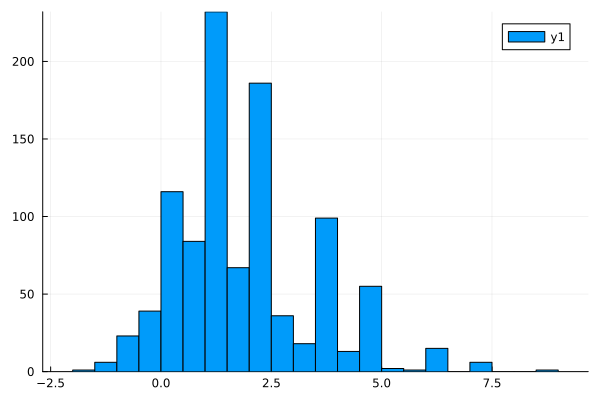

mean(m.strategy_vec .== C) = 0.48


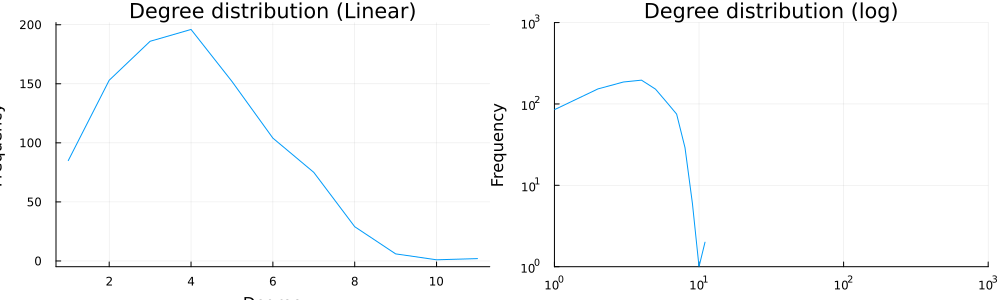

Test Summary:       |Time
run_one_generation! | None  1.2s


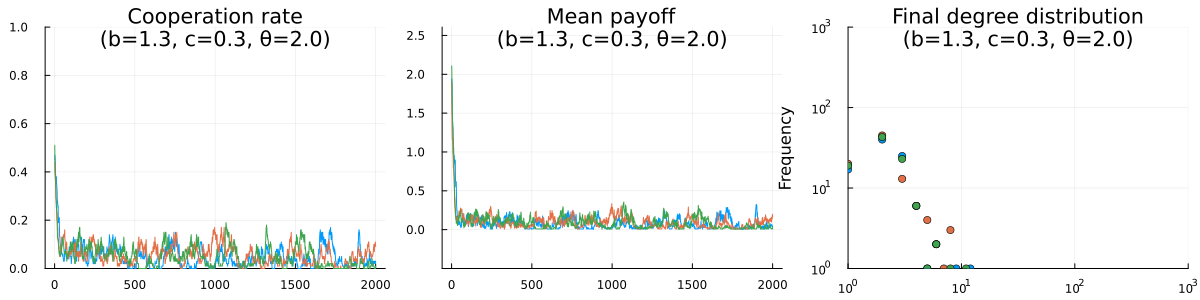

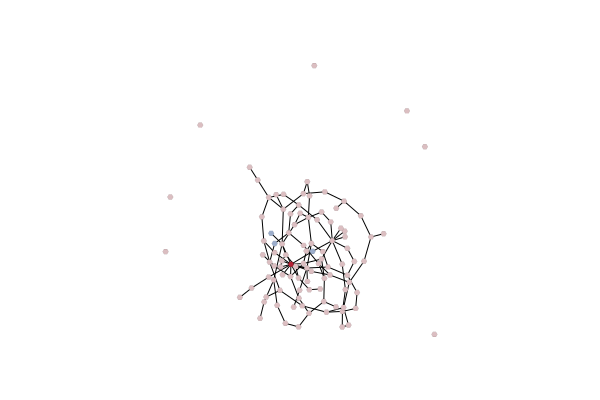

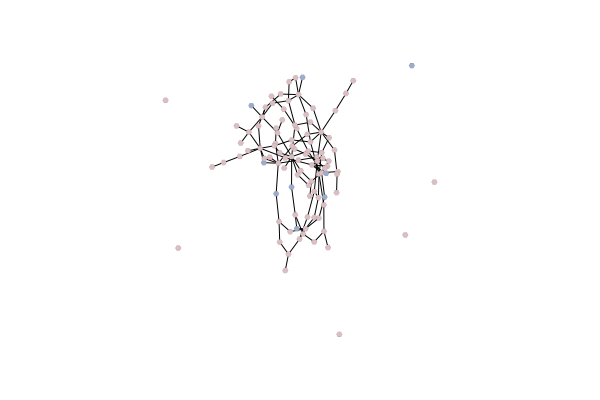

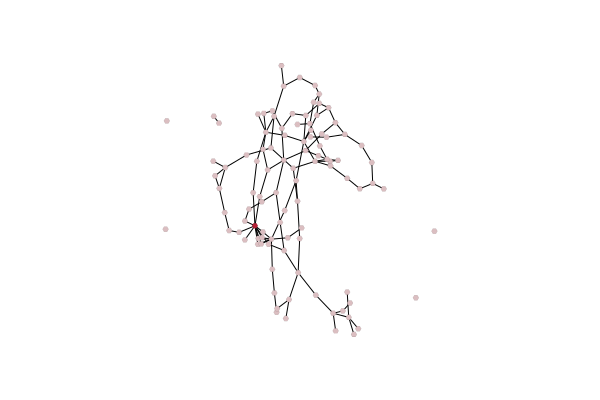

Test Summary: |Time
run!          | None  3.2s


In [11]:
@testset "run_one_generation!" begin
    m = Model(Param())

    # execute
    run_one_generation!(m)
    
    # payoff
    @show mean(m.payoff_vec)
    histogram(m.payoff_vec) |> display
    # @test maximum(m.payoff_vec) == 12.127599
    # @test minimum(m.payoff_vec) == 0.0

    # strategy
    @show mean(m.strategy_vec .== C)
    
    # graph
    degree_count = sort(Dict(k => v for (k, v) in degree_distribution(m.g) if k > 0))
    xs = collect(keys(degree_count))
    ys = [degree_count[x] for x in xs]
    plot(
        plot(xs, ys, xlabel="Degree", ylabel="Frequency", title="Degree distribution (Linear)", legend=false),
        plot(xs, ys, xscale=:log10, yscale=:log10, xlim=(1, 10^3), ylim=(1, 10^3), xlabel="Degree", ylabel="Frequency", title="Degree distribution (log)", legend=false),
        size = (1000, 300)
    ) |> display
end

function strategy_and_degree_to_color(strategy::Strategy, degree::Int)::RGB
    if strategy == C
        degree > 10 ? DARK_BLUE : LIGHT_BLUE
    else
        degree > 10 ? DARK_RED : LIGHT_RED
    end
end

@testset "run!" begin
    N, b, c, θ = (100, 1.3, 0.3, 2.0)
    result = run!(Param(N = N, b = b, c = c, θ = θ, trials = 3, generations = 2_000))
    plot_3chats(result[1:3]..., b, c, θ) |> display

    for trial in 1:3
        g = result[3][trial]
        strategy_vec = result[4][trial]

        nodefillc = [strategy_and_degree_to_color(s, d) for (s, d) in zip(strategy_vec, degree(g))]
        gp = graphplot(g, markercolor=nodefillc, curves=false, method=:spring, markerstrokewidth=0)
        display(gp)
    end
    # savefig(gp, "gp.png")
end;

## 2. Run simulation

In [12]:
function make_dir()::String
    timestamp = Dates.format(now(), "yyyymmdd_HHMM")
    dir_name = "img_$timestamp"
    mkdir(dir_name)

    return dir_name
end;

In [13]:
trials = 10
generations = 6_000

# b_vec = collect(1.0:0.05:1.5)
# c_vec = collect(0.0:0.05:0.5)
# θ_vec = collect(0:0.1:4)
b_vec = [1.3]
c_vec = [0.3]
θ_vec = [0.5]
# θ_vec = [9.9]

b_length = length(b_vec)
c_length = length(c_vec)
b_c_index_vec = [(b_index, c_index) for b_index in 1:b_length, c_index in 1:c_length]

dir_name = make_dir()

for θ in θ_vec
    results_mat = fill(0.0, b_length, c_length)
    plot_dic = Dict{String, Plot}()

    Threads.@threads for (b_index, c_index) in b_c_index_vec
        b = b_vec[b_index]
        c = c_vec[c_index]

        param = Param(b = b, c = c, θ = θ, trials = trials, generations = generations)
        C_rate_mat, mean_payoff_mat, final_degree_distribution_vec = run!(param)

        results_mat[b_index, c_index] = mean(C_rate_mat[:, round(Int, end * 0.9):end])

        p = plot_3chats(C_rate_mat, mean_payoff_mat, final_degree_distribution_vec, b, c, θ)
        plot_dic["θ$(θ)_b$(b)_c$(c).png"] = p
    end

    p = plot_b_c_heatmap(results_mat, b_vec, c_vec, θ)
    savefig(p, "$(dir_name)/c_rate_θ$(θ).png")

    for (file_name, p) in plot_dic
        savefig(p, "$(dir_name)/$(file_name)")
    end

    closeall()
end;

## 3. Results